In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
# # for persian
# !pip install hazm -q
# from hazm import *
import string
from collections import Counter
import random

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
import string
from torch.utils.data import Dataset, DataLoader

import pandas as pd
class dataframe_generator:
    def __init__(self, path):
        seperator = ' [SEP] '
        end = ' [END] '
        self.lines = self.file_reader(path)
        self.poems = []
        for line,beyt in enumerate(self.lines):
          if line >= 4:
              if line % 2 == 0:
                  Beyt = beyt[:-1] + seperator
              elif line % 2 == 1:
                  self.poems.append(Beyt + beyt[:-1] + end)
        self.df = pd.DataFrame(self.poems)
    def file_reader(self, path):
        with open(path, 'r', encoding='utf-8') as f:
            for row in f:
              yield row

class Fersdusi_Dataset(Dataset):
    def __init__(self, poem_path):
        self.poem_path = poem_path
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
        self.create_dataset()

    def __len__(self):
        return len(self.poem)-1

    def __getitem__(self, idx):
        return self.poem[idx], self.poem[idx+1] #each beyt is given and we want next beyt!

    def create_dataset(self):
        self.poem = dataframe_generator(self.poem_path).poems
        self.poem = [word_tokenize(line) for line in self.poem]
        self.poem = [self.clean_punctuatuin(line) for line in self.poem]
        self.max_len = max([len(line) for line in self.poem])
        self.poem = [self.make_same_length(line) for line in self.poem]
        self.poem = [self.add_end_and_start_token(line) for line in self.poem]
        self.create_vocab()
        self.poem = [[self.word2idx[word] for word in line] for line in self.poem]
        self.poem = torch.tensor(self.poem)
        
    def clean_punctuatuin(self,beyt):
        punctuations = string.punctuation + "<?><>.،؟،؛ََِِۀـّإـ,ـ«,ي"
        return [word for word in beyt if word not in punctuations]
    def make_same_length(self,beyt):
        return beyt + ['<pad>']*(self.max_len-len(beyt))
    def add_end_and_start_token(self,beyt):
        return ['<sos>'] + beyt + ['<eos>']
    def create_vocab(self):
        for beyt in self.poem:
            for word in beyt:
                self.addword(word)
        pass
    def addword(self,word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1
        pass



        
        


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from sklearn.model_selection import train_test_split
dataset = Fersdusi_Dataset('ferdousi.txt')
# split dataset with torch
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Number of data in train: {len(train_dataset)}')
print(f'Number of data in test: {len(test_dataset)}')

Number of data in train: 39684
Number of data in test: 9922


In [ ]:
### source of models is pytorch github ###
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, p_drop=0.2):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(p_drop)

    def forward(self, x, hidden=None, cell=None):
        embedding = self.dropout(self.embedding(x))
        if hidden is None and cell is None:
            hidden = torch.zeros((self.num_layers, x.shape[0], self.hidden_size), device=x.device)
            cell = torch.zeros((self.num_layers, x.shape[0], self.hidden_size), device=x.device)
        outputs, (hidden, cell) = self.rnn(embedding, (hidden, cell))
        return hidden, cell
class Decoder(nn.Module):
    def __init__(self, input_size,encoder_emebding ,embedding_size, hidden_size, output_size, num_layers, p_drop=0.2):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = encoder_emebding
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p_drop)

    def forward(self, x, hidden, cell):
        x = x.unsqueeze(1)
        embedding = self.dropout(self.embedding(x))
        outputs, (hidden, cell) = self.rnn(embedding, (hidden, cell))
        predictions = self.fc(outputs)
        predictions = predictions.squeeze(1)
        return predictions, hidden, cell
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    def forward(self, source, target, teacher_forcing_ratio=0.5):
        batch_size = source.shape[0]
        target_len = target.shape[1]
        target_vocab_size = len(dataset.word2idx)
        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(device)
        hidden, cell = self.encoder(source)
        x = target[:, 0]
        for t in range(1, target_len):
            output, hidden, cell = self.decoder(x, hidden, cell)
            outputs[:, t] = output
            best_guess = output.argmax(1)
            x = target[:, t] if random.random() < teacher_forcing_ratio else best_guess
        return outputs




class EncoderGRU(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, p_drop=0.2):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.GRU(embedding_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(p_drop)

    def forward(self, x, hidden=None, cell=None):
        # x.shape = (batch_size, seq_len)
        embedding = self.dropout(self.embedding(x))
        # embedding.shape = (batch_size, seq_len, embedding_size)
        if hidden is None and cell is None:
            hidden = torch.zeros((self.num_layers, x.shape[0], self.hidden_size), device=x.device)
            cell = torch.zeros((self.num_layers, x.shape[0], self.hidden_size), device=x.device)
        outputs, (hidden, cell) = self.rnn(embedding, (hidden, cell))

        return hidden, cell
class DecoderGRU(nn.Module):
    def __init__(self, input_size,encoder_emebding ,embedding_size, hidden_size, output_size, num_layers, p_drop=0.2):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = encoder_emebding
        self.rnn = nn.GRU(embedding_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p_drop)

    def forward(self, x, hidden, cell):
        x = x.unsqueeze(1)
        embedding = self.dropout(self.embedding(x))
        outputs, (hidden, cell) = self.rnn(embedding, (hidden, cell))
        predictions = self.fc(outputs)
        predictions = predictions.squeeze(1)
        return predictions, hidden, cell
class Seq2SeqGRU(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    def forward(self, source, target, teacher_forcing_ratio=0.5):
        batch_size = source.shape[0]
        target_len = target.shape[1]
        target_vocab_size = len(dataset.word2idx)
        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(device)
        hidden, cell = self.encoder(source)
        x = target[:, 0]
        for t in range(1, target_len):
            output, hidden, cell = self.decoder(x, hidden, cell)
            outputs[:, t] = output
            best_guess = output.argmax(1)
            x = target[:, t] if random.random() < teacher_forcing_ratio else best_guess
        return outputs

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def convert_to_sentence(output):
    sentence = []
    for idx in output:
        sentence.append(dataset.idx2word[idx] if idx != dataset.word2idx['<pad>'] else '')
    return sentence
def generate_sentence(model, source, max_len=50):
    source = source.unsqueeze(0)
    model.eval()
    with torch.no_grad():
        hidden, cell = model.encoder(source.to(device))
        x = torch.tensor([dataset.word2idx['<sos>']]).to(device)
        outputs = []
        for t in range(max_len):
            output, hidden, cell = model.decoder(x, hidden, cell)
            # output.shape = (1, output_size)
            best_guess = output.argmax(1)
            outputs.append(best_guess.item())
            x = best_guess
            if best_guess.item() == dataset.word2idx['<eos>']:
                break
        return convert_to_sentence(outputs)

def check_generated_verse(sentence):
    is_good = True
    repated_treshhold = 2
    repated = 0
    for i in range(len(sentence)-1):
        if sentence[i] == sentence[i+1]:
            repated += 1
            if repated > repated_treshhold:
                is_good = False
                return is_good
    if len(set(sentence)) < 3:
        is_good = False
        return is_good
    if len(sentence) < 25:
        is_good = False
        return is_good
    return is_good
def generate_good_sentence(model, source, max_len=50):
    for i in range(10):
        sentence = generate_sentence(model, source, max_len)
        if check_generated_verse(sentence):
            sentence = ' '.join(sentence)
            return sentence
    model.train()
    sentence = [word for word in sentence if word not in ['<eos>', '<pad>', '<sos>', '<unk>', 'SEP','END']]
    sentence = ' '.join(sentence)
    return sentence
def evalute_model_by_generate_sentence(model, num_of_sentences=3):
  ''' I USE this function to recheck generated sentence to be good . because the model is not complicated enough and our resources is limited '''
    for i in range(num_of_sentences):
        idx = random.randint(0, len(test_dataset))
        verse = test_dataset[idx][0].to(device)
    verse_generated = generate_good_sentence(model, verse)
    model.train()
    return verse_generated
    
def train(model, iterator, optimizer, criterion, clip, num_epochs,print_every=100, teacher_forcing_ratio=0.5,num_of_sentences=1):
    train_loss_list = []
    model.train()
    print(f"\n Generated before training {evalute_model_by_generate_sentence(model, num_of_sentences)}:\n")
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        for i, (source, target) in enumerate(iterator):
            source = source.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model(source, target, teacher_forcing_ratio)
            # output.shape = (batch_size, target_len, output_dim)
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            target = target[1:].view(-1)
            loss = criterion(output, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            epoch_loss += loss.item()
            if i % print_every == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(iterator)}], Loss: {loss.item():.4f}')
        train_loss_list.append(epoch_loss/len(iterator))
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss/len(iterator):.4f}')
    print(f"\n Generated After training : {evalute_model_by_generate_sentence(model, num_of_sentences)} \n")
    return model, train_loss_list
    

In [3]:
###### Train WITH LSTM MODEL ####
input_size_decoder = len(dataset.word2idx)
input_size_encoder = len(dataset.word2idx)
output_size = len(dataset.word2idx)
decoder_embedding_size = 50
encoder_embedding_size = 50
hidden_size = 100
num_layers = 1
num_epochs = 20
clip = 1

# create model
encoder_net = Encoder(input_size_encoder, encoder_embedding_size, hidden_size, num_layers).to(device)
decoder_net = Decoder(input_size_decoder,encoder_net.embedding, decoder_embedding_size, hidden_size, output_size, num_layers).to(device)
model_LSTM = Seq2Seq(encoder_net, decoder_net).to(device)
### train the model ### 
optimizer = optim.Adam(model_LSTM.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=dataset.word2idx['<pad>'])
model_LSTM_trained, train_losses_LSTM = train(model_LSTM, train_loader, optimizer, criterion, clip, num_epochs,print_every=500, teacher_forcing_ratio=0.2,num_of_sentences=1)



 Generated before training خوانی سرگذشت افسران کافرین بابکان مانوی درتاج نامورتان چوخستو داست بازگشت بیامدش بدنهاد سربریدن بیامدش سربریدن فسونی چنانند ببندد قیصرکشان ناگه ورشک طلایه بگذشته اشتر بهارم کنارنگی نیستتان چیم بشنو رشک بشنو بشنو بترسیدی تپد بکوب شراع بینوا بینوا بربر اندرآیی هرومش کردن باید اورمزدت بخوایید سمرقند انجا جوشنوران خویشت:

Epoch [1/20], Step [1/1241], Loss: 9.8047
Epoch [1/20], Step [501/1241], Loss: 6.0430
Epoch [1/20], Step [1001/1241], Loss: 5.9056
Epoch [1/20], Train Loss: 6.1615
Epoch [2/20], Step [1/1241], Loss: 5.9005
Epoch [2/20], Step [501/1241], Loss: 5.8881
Epoch [2/20], Step [1001/1241], Loss: 5.9510
Epoch [2/20], Train Loss: 5.9174
Epoch [3/20], Step [1/1241], Loss: 5.7792
Epoch [3/20], Step [501/1241], Loss: 5.6977
Epoch [3/20], Step [1001/1241], Loss: 6.0628
Epoch [3/20], Train Loss: 5.8700
Epoch [4/20], Step [1/1241], Loss: 5.8786
Epoch [4/20], Step [501/1241], Loss: 5.9798
Epoch [4/20], Step [1001/1241], Loss: 5.7637
Epoch [4/20], Train Loss: 5.8

In [5]:
## create the model ##
encoder_net_GRU = Encoder(input_size_encoder, encoder_embedding_size, hidden_size, num_layers).to(device)
decoder_net_GRU = Decoder(input_size_decoder,encoder_net.embedding, decoder_embedding_size, hidden_size, output_size, num_layers).to(device)
model_GRU = Seq2Seq(encoder_net_GRU, decoder_net_GRU).to(device)
##### TRAIN WITH GRU #####
optimizer = optim.Adam(model_GRU.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=dataset.word2idx['<pad>'])
num_epochs = 20
clip = 1
model_GRU , train_losses = train(model_GRU, train_loader, optimizer, criterion, clip, num_epochs,print_every=500, teacher_forcing_ratio=0.2,num_of_sentences=1)



Generated before training خسرو خسرو توآییم ناسپاسان فرونتر تختست بدکاستی ستیزه خدایا توخواهی کتان دربرتری عیار عیار بکوشم چوبالوی عیار عیار بکوشم چوبالوی عیار عیار بکوشم چوبالوی عیار عیار بکوشم چوبالوی عیار عیار بکوشم چوبالوی عیار عیار بکوشم چوبالوی عیار عیار بکوشم چوبالوی عیار عیار بکوشم چوبالوی عیار عیار بکوشم چوبالوی عیار عیار:

Epoch [1/20], Step [1/1241], Loss: 9.8006
Epoch [1/20], Step [501/1241], Loss: 6.1790
Epoch [1/20], Step [1001/1241], Loss: 5.7982
Epoch [1/20], Train Loss: 6.1307
Epoch [2/20], Step [1/1241], Loss: 5.9662
Epoch [2/20], Step [501/1241], Loss: 5.9200
Epoch [2/20], Step [1001/1241], Loss: 5.9358
Epoch [2/20], Train Loss: 5.8606
Epoch [3/20], Step [1/1241], Loss: 5.8567
Epoch [3/20], Step [501/1241], Loss: 5.8167
Epoch [3/20], Step [1001/1241], Loss: 5.8273
Epoch [3/20], Train Loss: 5.8197
Epoch [4/20], Step [1/1241], Loss: 5.9774
Epoch [4/20], Step [501/1241], Loss: 5.8160
Epoch [4/20], Step [1001/1241], Loss: 5.6584
Epoch [4/20], Train Loss: 5.7918
Epoch [5/

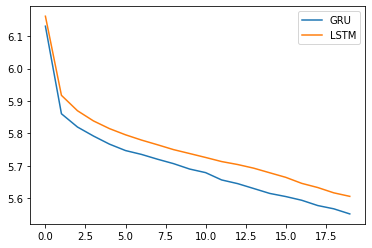

In [ ]:
plt.plot(train_losses, label='GRU')
plt.plot(train_losses_LSTM, label='LSTM')
plt.legend()
plt.show()

**AS plot showing , GRU is working better in this task**